# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
#from numba import cuda
from scipy import spatial, sparse

In [2]:
data = pd.read_csv('/mnt/d/wildfires/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

/home/mark/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mark/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


making doy relative to year, equal to days since 1/1/1992 now

In [3]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

## Sort data by day

In [4]:
%%time
data = data.sort_values('DAY', ascending=True, kind='mergesort')

CPU times: user 906 ms, sys: 1.22 s, total: 2.12 s
Wall time: 2.11 s


# Using both
Threshold: only if edge meets **both** criteria

In [5]:
def get_block(values, dist, row_start, row_end, col_start, col_end):
    
    N = values.shape[0]

    # Get the relevant values for this block
    #print("Get row/col vals")
    row_values = values[row_start:row_end, :]
    col_values = values[col_start:col_end, :]

    # Get distance matrix for this block
    #print("Calculate distance")
    # use cuda implementation from stackoverflow
    D = spatial.distance.cdist(row_values, col_values)

    # Threshold it
    #print("Threshold it")
    subA = D <= dist
    
    return subA

def get_A_both(data_space, dist_space, data_time, dist_time, blocksize=10000):
    
    print("Setting up...")
    space_values = np.array(data_space.values)
    time_values = np.array(data_time.values)
    
    # Dimensions should be be (N, K), even if K = 1 columns. Reshape if needed
    if len(space_values.shape) == 1:
        space_values = space_values.reshape((space_values.shape[0], 1))
    if len(time_values.shape) == 1:
        time_values = time_values.reshape((time_values.shape[0], 1))
        
    assert space_values.shape[0] == time_values.shape[0], "Datasets must have same number of observations"
    N = space_values.shape[0]
        
    print("Initializing sparse matrix...")
    # Initialize sparse matrix
    A = sparse.lil_matrix((N,N))
    
    # Divide-and-conquer: split the overall big adjacency matrix into
    # blocksize x blocksize chunks, then use scipy's super-fast C implementation for distance matrix
    for i in range(N // blocksize + 1):
        skip_row = False
            
        for j in range(i, N // blocksize + 1):
            
            if skip_row:
                continue
            
            # Make sure we don't go out of bounds if N isn't divisible by blocksize!
            row_start = i * blocksize
            row_end   = min((i+1) * blocksize, N-1)
            col_start = j * blocksize
            col_end   = min((j+1) * blocksize, N-1)
            
            sub_A_time = get_block(time_values, dist_time, row_start, row_end, col_start, col_end)
            
            if (sub_A_time == 0).all():
                #print((i,j))
                #print("No more non-zeroes column-wise on this row!  Skipping to next")
                skip_row = True
                
            sub_A_space = get_block(space_values, dist_space, row_start, row_end, col_start, col_end)
            
            # Insert into matrix
            #print("Insert into matrix")
            subA = sub_A_time * sub_A_space            
            
            A[row_start:row_end, col_start:col_end] = subA
            
            # This graph is undirected--A will be symmetric! So set the other side now
            #if i != j:
                #print("Insert into matrix, transposed")
                #A[col_start:col_end, row_start:row_end] = subA.T
            
    # Convert to CSR format for fast arithmetic
    #print("Convert CSR")
    A = A.tocsr()
    
    # This graph is undirected--so set the other side to be symmetric
    # Do this efficiently by adding the transpose, and then removing the elements equal to 2 to 1
    A += A.T
    A[A == 2] = 1
            
    return A

In [6]:
attr_time = data[["DAY"]]
attr_space = data[["LATITUDE", "LONGITUDE"]]

In [7]:
%%time
Aboth = get_A_both(attr_space, 1.0, attr_time, 1.01, blocksize=100)

Setting up...
Initializing sparse matrix...
CPU times: user 1min 27s, sys: 7.58 s, total: 1min 35s
Wall time: 1min 35s


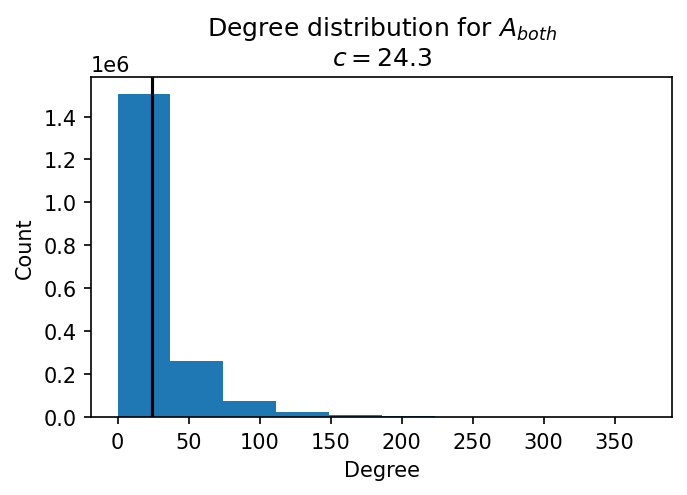

In [8]:
deg = Aboth.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Save sparse matrices to disk

In [9]:
with open('A_both_full.pkl', 'wb') as f:
    pickle.dump(Aboth, f)